=== Part A: Synthetic Dataset ===
Loaded synthetic dataset from: /content/dropout_synthetic.csv
Synthetic: shape = (1000, 12)

Class balance:
dropout
0    800
1    200
Name: count, dtype: int64

Class balance (%):
dropout
0    80.0
1    20.0
Name: proportion, dtype: float64

Numerical describe:


,count,mean,std,min,25%,50%,75%,max
student_id,1000.0,500.500000,288.819436,1.000000,250.750000,500.500000,750.250000,1000.0
age,950.0,25.384211,6.452123,-3.000000,20.000000,25.000000,30.000000,100.0
hs_gpa,970.0,3.616838,0.667780,-1.000000,3.187670,3.617535,4.024488,9.0
admission_score,980.0,69.889905,13.497961,-25.000000,61.769252,70.093419,78.009997,200.0
first_sem_gpa,900.0,3.194098,0.800141,0.378615,2.644708,3.195772,3.764734,5.0
socioeconomic_level,980.0,3.364286,1.343448,1.000000,2.000000,3.000000,4.000000,6.0
dropout,1000.0,0.200000,0.400200,0.000000,0.000000,0.000000,0.000000,1.0



Categorical frequencies (top 10 per column):

gender:
gender
Female    500
Male      500
Name: count, dtype: int64

origin:
origin
Urban    696
Rural    304
Name: count, dtype: int64

scholarship:
scholarship
No     657
Yes    333
NaN     10
Name: count, dtype: int64

loan:
loan
No     573
Yes    417
NaN     10
Name: count, dtype: int64

financial_aid:
financial_aid
No     772
Yes    218
NaN     10
Name: count, dtype: int64


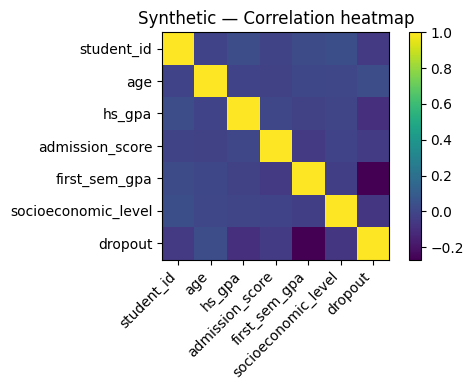


Top 5 strongest absolute correlations:
first_sem_gpa  dropout                0.267999
dropout        first_sem_gpa          0.267999
               hs_gpa                 0.095593
hs_gpa         dropout                0.095593
dropout        socioeconomic_level    0.066485
dtype: float64
Synthetic — 5-fold CV (training set, F1):
  Logistic Regression: mean=0.149 ± 0.028
  Decision Tree      : mean=0.300 ± 0.072

Synthetic — Test metrics: Logistic Regression
  Accuracy : 0.815
  Precision: 0.714
  Recall   : 0.125
  F1-score : 0.213
  ROC-AUC  : 0.738

Classification report:
              precision    recall  f1-score   support

           0      0.819     0.988     0.895       160
           1      0.714     0.125     0.213        40

    accuracy                          0.815       200
   macro avg      0.766     0.556     0.554       200
weighted avg      0.798     0.815     0.759       200



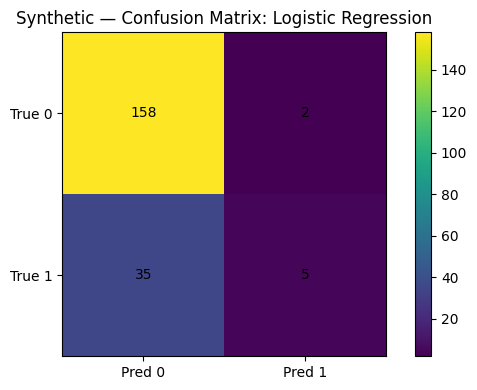

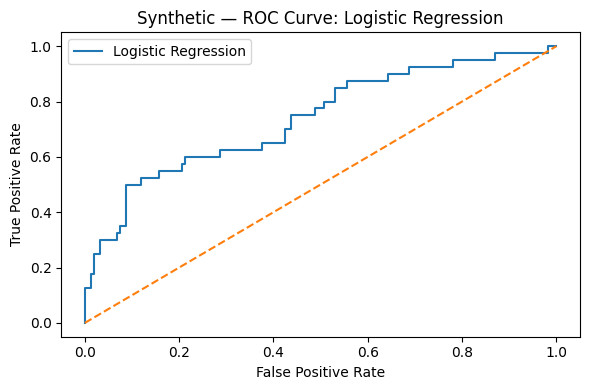


Synthetic — Test metrics: Decision Tree
  Accuracy : 0.710
  Precision: 0.295
  Recall   : 0.325
  F1-score : 0.310
  ROC-AUC  : 0.566

Classification report:
              precision    recall  f1-score   support

           0      0.827     0.806     0.816       160
           1      0.295     0.325     0.310        40

    accuracy                          0.710       200
   macro avg      0.561     0.566     0.563       200
weighted avg      0.721     0.710     0.715       200



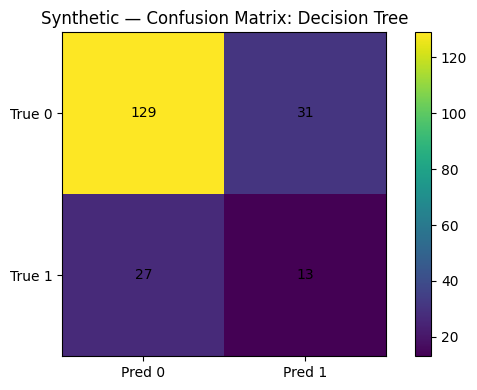

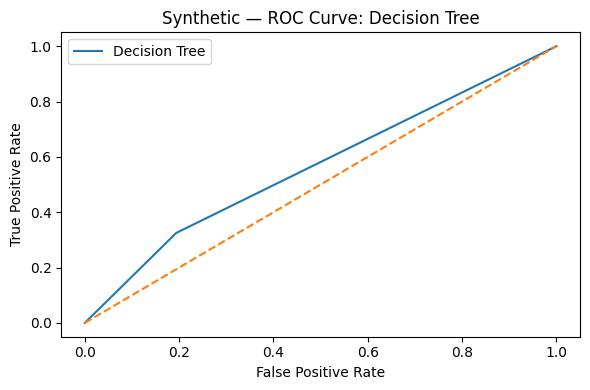


Model selection (sorted by F1 on test):


,accuracy,precision,recall,f1,roc_auc
model,,,,,
Decision Tree,0.710,0.295455,0.325,0.309524,0.565625
Logistic Regression,0.815,0.714286,0.125,0.212766,0.738281



Selected model for Synthetic: **Decision Tree** (based on F1).

=== Part B: Attached Dataset (student_dropout.csv) ===
Attached dataset not found. Upload 'student_dropout.csv' to the Colab working directory to run Part B.

=== Conclusions ===
- Compared Logistic Regression and Decision Tree with identical preprocessing and 5-fold CV (F1).
- Reported: Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix, ROC curves on the test set.
- Selected the model with the highest F1 for each dataset.
- Next steps: hyperparameter tuning, probability calibration, capacity-aware thresholding (~80% recall).


In [1]:

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

RANDOM_STATE = 42
plt.rcParams.update({"figure.figsize": (6,4)})

# --------------------------------------------
# Synthetic dataset generator (from Activity 1)
# --------------------------------------------
def generate_dropout_dataset(N=1000, seed=7):
    rng = np.random.default_rng(seed)

    # Demographics
    age = rng.integers(16, 35, size=N).astype(float)
    gender = rng.choice(["Female","Male"], size=N, p=[0.48, 0.52])
    origin = rng.choice(["Urban","Rural"], size=N, p=[0.72, 0.28])

    # Academics
    hs_gpa = np.clip(rng.normal(3.6, 0.6, size=N), 1.0, 5.0)
    admission_score = np.clip(rng.normal(70, 12, size=N), 20, 100)
    first_sem_gpa = np.clip(rng.normal(3.2, 0.8, size=N), 0.0, 5.0)

    # Financial
    socioeconomic_level = rng.choice([1,2,3,4,5,6], size=N, p=[0.10,0.18,0.28,0.22,0.16,0.06])
    scholarship = rng.choice(["Yes","No"], size=N, p=[0.35, 0.65])
    loan = rng.choice(["Yes","No"], size=N, p=[0.42, 0.58])
    financial_aid = rng.choice(["Yes","No"], size=N, p=[0.22, 0.78])

    # Logistic DGP for dropout (computed BEFORE nulls/outliers)
    sex_n = (gender=="Female").astype(int)
    origin_n = (origin=="Rural").astype(int)
    ses_n = socioeconomic_level.astype(float)

    z = (
        -0.2
        - 0.7*(hs_gpa - 3.0)
        - 0.5*((admission_score - 60)/20.0)
        - 1.2*((first_sem_gpa - 2.5)/1.0)
        - 0.15*sex_n
        + 0.25*origin_n
        - 0.35*(scholarship=="Yes")
        + 0.20*(loan=="Yes")
        - 0.25*(financial_aid=="Yes")
        + 0.18*(3 - np.clip(ses_n, 1, 6))
        + 0.05*((age - 18)/5.0)
    )
    p = 1/(1 + np.exp(-z))
    dropout = (rng.uniform(size=N) < p).astype(int)

    df = pd.DataFrame({
        "student_id": np.arange(1, N+1),
        "age": age,
        "gender": gender,
        "origin": origin,
        "hs_gpa": hs_gpa,
        "admission_score": admission_score,
        "first_sem_gpa": first_sem_gpa,
        "socioeconomic_level": socioeconomic_level,
        "scholarship": scholarship,
        "loan": loan,
        "financial_aid": financial_aid,
        "dropout": dropout
    })

    # Outliers
    oi = rng.choice(N, size=18, replace=False)
    df.loc[oi[:6], "age"] = [60, 15, 80, -3, 100, 2]
    df.loc[oi[6:12], "hs_gpa"] = [7.0, -1.0, 6.5, 5.8, 0.0, 9.0]
    df.loc[oi[12:], "admission_score"] = [130, -10, 125, 140, 200, -25]

    # Nulls (MAR/MNAR mix)
    rng_nulls = np.random.default_rng(seed + 123)
    def inject_nulls(s, frac):
        s = s.copy()
        k = max(1, int(frac*len(s)))
        idx = rng_nulls.choice(s.index, size=k, replace=False)
        s.loc[idx] = np.nan
        return s

    df["age"] = inject_nulls(df["age"], 0.05)
    df["hs_gpa"] = inject_nulls(df["hs_gpa"], 0.03)
    df["admission_score"] = inject_nulls(df["admission_score"], 0.02)
    df["first_sem_gpa"] = inject_nulls(df["first_sem_gpa"], 0.10)
    df["socioeconomic_level"] = inject_nulls(df["socioeconomic_level"], 0.02)
    df["scholarship"] = inject_nulls(df["scholarship"], 0.01)
    df["loan"] = inject_nulls(df["loan"], 0.01)
    df["financial_aid"] = inject_nulls(df["financial_aid"], 0.01)

    return df

# --------------------------------------------
# Quick EDA + correlation heatmap
# --------------------------------------------
def quick_eda(df, target="dropout", title_prefix="Dataset"):
    print(f"{title_prefix}: shape = {df.shape}")

    print("\nClass balance:")
    if target in df.columns:
        print(df[target].value_counts(dropna=False))
        print("\nClass balance (%):")
        print((df[target].value_counts(normalize=True)*100).round(2))
    else:
        print(f"Target '{target}' not found.")

    # Numerical / categorical summaries
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()
    if target in df.columns and target not in num_cols:
        try:
            df[target] = pd.to_numeric(df[target], errors="coerce")
            num_cols = df.select_dtypes(include=["number"]).columns.tolist()
        except Exception:
            pass

    print("\nNumerical describe:")
    display(df[num_cols].describe().T)

    print("\nCategorical frequencies (top 10 per column):")
    for c in cat_cols:
        print(f"\n{c}:")
        print(df[c].value_counts(dropna=False).head(10))

    # Correlation heatmap (numeric)
    num_for_corr = df.select_dtypes(include=["number"]).copy()
    corr = num_for_corr.corr(numeric_only=True)

    plt.figure()
    im = plt.imshow(corr, interpolation="nearest")
    plt.title(f"{title_prefix} — Correlation heatmap")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout()
    plt.show()

    corr_pairs = (
        corr.where(~np.eye(corr.shape[0],dtype=bool))
            .stack()
            .abs()
            .sort_values(ascending=False)
    )
    print("\nTop 5 strongest absolute correlations:")
    print(corr_pairs.head(5))

# --------------------------------------------
# Preprocess + models + CV + evaluation
# --------------------------------------------
def run_models(df, target="dropout", title_prefix="Dataset"):
    if target not in df.columns:
        raise ValueError(f"Target '{target}' not in dataframe.")
    df2 = df.copy()
    df2[target] = pd.to_numeric(df2[target], errors="coerce")
    df2 = df2.dropna(subset=[target])
    df2[target] = df2[target].astype(int)

    X = df2.drop(columns=[target])
    y = df2[target]

    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer(transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ])

    logreg = LogisticRegression(max_iter=1000)
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    pipe_lr = Pipeline(steps=[("pre", pre), ("clf", logreg)])
    pipe_dt = Pipeline(steps=[("pre", pre), ("clf", tree)])

    # 5-fold CV on training (F1)
    cv_lr = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring="f1")
    cv_dt = cross_val_score(pipe_dt, X_train, y_train, cv=5, scoring="f1")

    print(f"{title_prefix} — 5-fold CV (training set, F1):")
    print(f"  Logistic Regression: mean={cv_lr.mean():.3f} ± {cv_lr.std():.3f}")
    print(f"  Decision Tree      : mean={cv_dt.mean():.3f} ± {cv_dt.std():.3f}")

    # Fit
    pipe_lr.fit(X_train, y_train)
    pipe_dt.fit(X_train, y_train)

    # Evaluate on test
    def evaluate(pipe, model_name):
        y_pred = pipe.predict(X_test)
        try:
            y_prob = pipe.predict_proba(X_test)[:,1]
        except Exception:
            y_scores = pipe.decision_function(X_test)
            y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_prob)

        print(f"\n{title_prefix} — Test metrics: {model_name}")
        print(f"  Accuracy : {acc:.3f}")
        print(f"  Precision: {prec:.3f}")
        print(f"  Recall   : {rec:.3f}")
        print(f"  F1-score : {f1:.3f}")
        print(f"  ROC-AUC  : {auc:.3f}")
        print("\nClassification report:")
        print(classification_report(y_test, y_pred, digits=3))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure()
        plt.imshow(cm)
        plt.title(f"{title_prefix} — Confusion Matrix: {model_name}")
        plt.colorbar()
        plt.xticks([0,1], ["Pred 0","Pred 1"]); plt.yticks([0,1], ["True 0","True 1"])
        for (i,j), v in np.ndenumerate(cm):
            plt.text(j, i, int(v), ha="center", va="center")
        plt.tight_layout(); plt.show()

        # ROC Curve
        fpr, tpr, thr = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name}")
        plt.plot([0,1],[0,1], linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{title_prefix} — ROC Curve: {model_name}")
        plt.legend()
        plt.tight_layout(); plt.show()

        return {"model": model_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

    res_lr = evaluate(pipe_lr, "Logistic Regression")
    res_dt = evaluate(pipe_dt, "Decision Tree")

    results = pd.DataFrame([res_lr, res_dt]).set_index("model").sort_values("f1", ascending=False)
    print("\nModel selection (sorted by F1 on test):")
    display(results)

    best = results.index[0]
    print(f"\nSelected model for {title_prefix}: **{best}** (based on F1).")

    return {"cv_lr": cv_lr, "cv_dt": cv_dt, "results": results}

# =========================
# Part A — Synthetic Dataset
# =========================
print("=== Part A: Synthetic Dataset ===")
synth_paths = [
    "/content/dropout_synthetic.csv",
    "/content/drive/MyDrive/dropout_synthetic.csv",
    "/mnt/data/dropout_synthetic.csv"
]
df_synth = None
for p in synth_paths:
    if os.path.exists(p):
        df_synth = pd.read_csv(p)
        print("Loaded synthetic dataset from:", p)
        break
if df_synth is None:
    df_synth = generate_dropout_dataset(N=1000, seed=7)
    print("Generated synthetic dataset (since CSV not found).")

quick_eda(df_synth, target="dropout", title_prefix="Synthetic")
out_synth = run_models(df_synth, target="dropout", title_prefix="Synthetic")

# =========================
# Part B — Attached Dataset
# =========================
print("\n=== Part B: Attached Dataset (student_dropout.csv) ===")
attach_paths = [
    "/content/student_dropout.csv",
    "/content/drive/MyDrive/student_dropout.csv",
    "/mnt/data/student_dropout.csv"
]
df_att = None
for p in attach_paths:
    if os.path.exists(p):
        df_att = pd.read_csv(p)
        print("Loaded attached dataset from:", p)
        break

if df_att is None:
    print("Attached dataset not found. Upload 'student_dropout.csv' to the Colab working directory to run Part B.")
else:
    # Try to standardize target column to 'dropout' (heuristics)
    cols_lower = {c.lower(): c for c in df_att.columns}
    target = "dropout"
    if "dropout" not in cols_lower:
        for cand in ["target", "label", "y", "is_dropout", "dropped", "drop_out"]:
            if cand in cols_lower:
                target = cols_lower[cand]
                break
        else:
            target = list(df_att.columns)[-1]
            print(f"Target not found explicitly. Using last column as target: {target}")

    quick_eda(df_att, target=target, title_prefix="Attached")
    out_att = run_models(df_att, target=target, title_prefix="Attached")

# =========================
# Conclusions (printed)
# =========================
print("\n=== Conclusions ===")
print("- Compared Logistic Regression and Decision Tree with identical preprocessing and 5-fold CV (F1).")
print("- Reported: Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix, ROC curves on the test set.")
print("- Selected the model with the highest F1 for each dataset.")
print("- Next steps: hyperparameter tuning, probability calibration, capacity-aware thresholding (~80% recall).")
